## AIML331 Assignment 3 Continued
### crowelenn, 300607096

In the second part of this assignment, the focus is on using vision transformers for image classification.

#### Setup

In [1]:
from dataset_wrapper import get_pet_datasets
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

In [2]:
train_dataset, val_dataset, test_dataset = get_pet_datasets(img_width=128, img_height=128,root_path='./data' )

In [3]:
print(f"Loaded data, train = {len(train_dataset)}, test = {len(test_dataset)}")

Loaded data, train = 5719, test = 716


In [4]:
print(torch.cuda.is_available())
compute_device = torch.device('cuda:0')

True


In [5]:
# load the datasets
batch_size = 32
training_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

testing_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Building the vision transformer

In [6]:
import numpy as np
def get_embedding(positions, dim):
    position = torch.arange(positions).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dim, 2) * (-np.log(10000.0) / dim))

    pe = torch.zeros(positions, dim)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    return pe.unsqueeze(0)

def image_to_patch(x, patch_size):
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)
    x = x.flatten(1,2)
    return x

In [7]:
class AttentionBlock(nn.Module):
    def __init__(self, embedding_dims, hidden_dims, count_heads, dropout=0.2):
        super().__init__()

        self.layer_normalisation_1 = nn.LayerNorm(embedding_dims)
        self.Attention = nn.MultiheadAttention(embedding_dims, num_heads=count_heads, dropout=dropout)
        self.layer_normalisation_2 = nn.LayerNorm(embedding_dims)
        self.Linear = nn.Sequential(
            nn.Linear(embedding_dims, hidden_dims),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims, embedding_dims),
            nn.Dropout(dropout)
        )

    def forward(self, input_x):
        input_norm = self.layer_normalisation_1(input_x)
        attention_out, _ = self.Attention(input_norm, input_norm, input_norm)
        input_x = input_x + attention_out

        norm_out = self.layer_normalisation_2(input_x)
        input_x = input_x + self.Linear(norm_out)

        return input_x

In [8]:
class PetsViT(nn.Module):
    def __init__(self, embedding_dims=60, hidden_dims=256, channels=3, count_heads=3, count_layers=3, classes=4, patch_size=16, input_dims=128, dropout=0.2, learnable_positional_embeddings=False):
        super().__init__()

        self.count_patches = (input_dims//patch_size)*(input_dims//patch_size)
        self.patch_size = patch_size

        # neural net layers
        self.input_layer = nn.Linear(channels*(patch_size*patch_size), embedding_dims)
        self.transformer = nn.Sequential(*[AttentionBlock(embedding_dims, hidden_dims, count_heads, dropout=dropout) for _ in range(count_layers)])
        self.mlp = nn.Sequential(
            nn.LayerNorm(embedding_dims),
            nn.Linear(embedding_dims, classes)
        )
        self.dropout = nn.Dropout(dropout)

        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dims))
        if learnable_positional_embeddings:
            self.position_embeddings = nn.Parameter(torch.randn(1, 1 + self.count_patches, embedding_dims))
        else:
            self.register_buffer('position_embeddings', get_embedding(1 + self.count_patches, embedding_dims))

    def forward(self, x):
        x = image_to_patch(x, self.patch_size)
        x = x.flatten(2,4)
        B, T, _ = x.shape
        x = self.input_layer(x)

        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.position_embeddings[:,:T+1]

        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        cls = x[0]
        out = self.mlp(cls)
        return out

#### Copy the train & test functions from the previous question

In [9]:
def reset_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.reset_parameters()

def do_training(model, experiment_name, criterion, optimizer, num_epochs=20, patience=5):
    writer = SummaryWriter('runs/'+experiment_name)

    min_validation_loss = None
    best_model_state = None # store the best model here. Re-instate this if early stopping is triggered
    wait = 0

    model.apply(reset_weights)

    steps = len(training_dataloader)
    for epoch in range(num_epochs): # epoch iteration loop
        model.train()
        train_loss_epoch_total = 0
        batches_count = 0

        for i, (images, labels) in enumerate(training_dataloader):

            if i == 0:
                writer.add_graph(model, images.to(compute_device))
            images = images.to(compute_device)
            labels = labels.to(compute_device)

            # forwards
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backpropogation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_epoch_total += loss.item()
            batches_count += 1

        train_loss = train_loss_epoch_total / batches_count
        writer.add_scalar('Loss/train', train_loss, epoch+1)

        # validation accuracy
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            val_loss_epoch_total = 0
            val_batches_count = 0

            for images, labels in validation_dataloader:
                images = images.to(compute_device)
                labels = labels.to(compute_device)
                outputs = model(images)
                val_loss = criterion(outputs, labels)

                val_loss_epoch_total += val_loss.item()
                val_batches_count += 1

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_loss = val_loss_epoch_total / val_batches_count

        writer.add_scalar('Accuracy/validation', val_acc, epoch)
        writer.add_scalar('Loss/validation', val_loss, epoch)

        if min_validation_loss is None or val_loss < min_validation_loss:
            min_validation_loss = val_loss
            best_model_state = model.state_dict() # save the best weights
            wait = 0
        else:
            wait += 1

        if wait >= patience:
            break # exit early if there has been no improvement in validation loss

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Best model weights restored.")

    writer.close()

    return model

In [10]:
def do_testing(model, dataloader):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataloader:
            images = images.to(compute_device)
            labels = labels.to(compute_device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total

        return accuracy, 'Accuracy of the model on the provided images: {} %'.format(accuracy)

#### Define a model for each test

In [11]:
baseline_model = PetsViT().to(compute_device)

# vary the attention heads
model_attn_4 = PetsViT(count_heads=4).to(compute_device)
model_attn_5 = PetsViT(count_heads=5).to(compute_device)
model_attn_6 = PetsViT(count_heads=6).to(compute_device)

# vary the layers
model_layers_4 = PetsViT(count_layers=4).to(compute_device)
model_layers_5 = PetsViT(count_layers=5).to(compute_device)
model_layers_6 = PetsViT(count_layers=6).to(compute_device)

# vary the patch sizes
model_patches_8 = PetsViT(patch_size=8).to(compute_device)
model_patches_4 = PetsViT(patch_size=4).to(compute_device)

# test with/without positional embeddings
model_positionalembeddings = PetsViT(learnable_positional_embeddings=True).to(compute_device)

In [17]:
models_params = [baseline_model, model_attn_4, model_attn_5, model_attn_6, model_layers_4, model_layers_5, model_layers_6, model_patches_8, model_patches_4]
model_param_counts = []

for i in range(len(models_params)):
    model_param_counts.append(sum(param.numel() for param in models_params[i].parameters()))

(array([2., 0., 4., 0., 1., 0., 0., 1., 0., 1.]),
 array([141112. , 159206.8, 177301.6, 195396.4, 213491.2, 231586. ,
        249680.8, 267775.6, 285870.4, 303965.2, 322060. ]),
 <BarContainer object of 10 artists>)

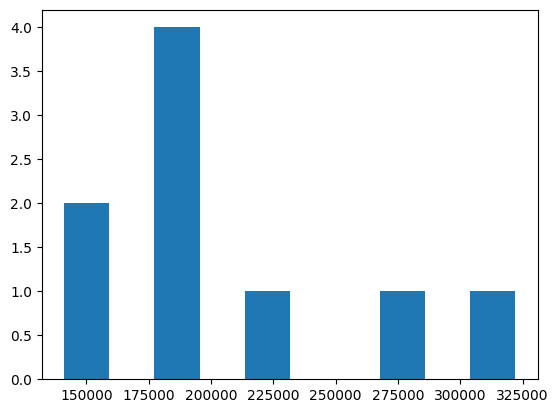

In [18]:
import matplotlib.pyplot as plt

plt.hist(model_param_counts)

#### Run the experiments

In [12]:
weights = [600/7149, 1771/7149, 2590/7149, 2188/7149]
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)
learning_rate = 0.001

In [13]:
# train the baseline model
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=learning_rate)

baseline_trained = do_training(baseline_model, 'vision_transformer_baseline', criterion, optimizer, num_epochs=100, patience=20)

Best model weights restored.


In [14]:
acc, acc_string = do_testing(baseline_trained, testing_dataloader)
print(acc_string)

Accuracy of the model on the provided images: 46.927374301675975 %


#### 4 Attention Heads

In [15]:
optim = torch.optim.Adam(model_attn_4.parameters(), lr=learning_rate)
attn_4_trained = do_training(model_attn_4, 'vision_transformer_4_attn', criterion, optim, num_epochs=100, patience=20)
acc, acc_string = do_testing(attn_4_trained, testing_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 45.94972067039106 %


#### 5 Attention Heads

In [16]:
optim = torch.optim.Adam(model_attn_5.parameters(), lr=learning_rate)
attn_5_trained = do_training(model_attn_5, 'vision_transformer_5_attn', criterion, optim, num_epochs=100, patience=20)
acc, acc_string = do_testing(attn_5_trained, testing_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 47.20670391061452 %


#### 6 Attention Heads

In [17]:
optim = torch.optim.Adam(model_attn_6.parameters(), lr=learning_rate)
attn_6_trained = do_training(model_attn_6, 'vision_transformer_6_attn', criterion, optim, num_epochs=100, patience=20)
acc, acc_string = do_testing(attn_6_trained, testing_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 44.41340782122905 %


#### 4 Transformer Layers

In [18]:
optim = torch.optim.Adam(model_layers_4.parameters(), lr=learning_rate)
model_layers_4_trained = do_training(model_layers_4, 'vision_transformer_4_layers', criterion, optim, num_epochs=100, patience=20)
acc, acc_string = do_testing(model_layers_4_trained, testing_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 46.229050279329606 %


#### 5 Transformer Layers

In [19]:
optim = torch.optim.Adam(model_layers_5.parameters(), lr=learning_rate)
model_layers_5_trained = do_training(model_layers_5, 'vision_transformer_5_layers', criterion, optim, num_epochs=100, patience=20)
acc, acc_string = do_testing(model_layers_5_trained, testing_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 49.16201117318436 %


#### 6 Transformer Layers

In [20]:
optim = torch.optim.Adam(model_layers_6.parameters(), lr=learning_rate)
model_layers_6_trained = do_training(model_layers_6, 'vision_transformer_6_layers', criterion, optim, num_epochs=100, patience=20)
acc, acc_string = do_testing(model_layers_6_trained, testing_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 45.53072625698324 %


#### Learnable Positional Embeddings

In [22]:
optim = torch.optim.Adam(model_positionalembeddings.parameters(), lr=learning_rate)
model_posembeddings_trained = do_training(model_positionalembeddings, 'vision_transformer_posembeddings', criterion, optim, num_epochs=100, patience=20)
acc, acc_string = do_testing(model_posembeddings_trained, testing_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 47.625698324022345 %


#### Patch Size of 8

In [21]:
optim = torch.optim.Adam(model_patches_8.parameters(), lr=learning_rate)
model_patches_8_trained = do_training(model_patches_8, 'vision_transformer_8_patchsize', criterion, optim, num_epochs=100, patience=20)
acc, acc_string = do_testing(model_patches_8_trained, testing_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 53.072625698324025 %


#### Patch Size of 4

In [22]:
optim = torch.optim.Adam(model_patches_4.parameters(), lr=0.005)
model_patches_4_trained = do_training(model_patches_4, 'vision_transformer_4_patchsize', criterion, optim, num_epochs=60, patience=7)
acc, acc_string = do_testing(model_patches_4_trained, testing_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 39.944134078212294 %


### Testing the inference time
I am training a new baseline model, as I have already written the bulk of the report, and don't want to have to update the baseline model accuracy & figures throughout.

In [19]:
baseline_model_inference = PetsViT().to(compute_device)

weights = [600 / 7149, 1771 / 7149, 2590 / 7149, 2188 / 7149]
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)
learning_rate = 0.001
# train the baseline model
optimizer = torch.optim.Adam(baseline_model_inference.parameters(), lr=learning_rate)

baseline_trained = do_training(baseline_model_inference, 'vision_transformer_baseline_inference', criterion, optimizer, num_epochs=100, patience=20)

Best model weights restored.


In [20]:
import time

baseline_trained.eval()

total_time = 0.0
total_images = 0

with torch.no_grad():
    for inputs, _ in testing_dataloader:
        inputs = inputs.to(compute_device)
        batch_size = inputs.size(0)

        start_time = time.time()
        _ = baseline_trained(inputs)
        end_time = time.time()

        total_time += end_time - start_time
        total_images += batch_size

average_inference = total_time / total_images
print(f"Average image inference time: {average_inference}")

Average image inference time: 7.797452990569216e-05
